# Predicting star rating based upon text reviews on Yelp

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

The review file (taken from [here](https://www.kaggle.com/yelp-dataset/yelp-dataset)) is nearly 4GB and contains nearly 5.3 million rows, so start by loading a few rows, just to get a sense of the structure

In [3]:
reviews = pd.read_csv('input/yelp_review.csv', nrows = 5)
reviews

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


We'll just a subset of these columns, and only work with the first 500,000 reviews

In [4]:
reviews = pd.read_csv('input/yelp_review.csv', usecols = ['business_id', 'stars', 'text'], nrows = 500000)
reviews.shape

(500000, 3)

## EDA

Initial plot of star distribution shows that data is imbalanced, so we'll need to be careful when assessing the accuracy of any classifiers

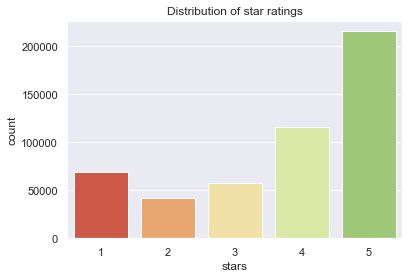

In [5]:
# Plot distribution of counts by class
sns.set(style="darkgrid")
sns.set_palette("RdYlGn")
plt.title('Distribution of star ratings')
_ = sns.countplot('stars', data=reviews)


In [6]:
# Display percentage of total number of reviews for each class
base_classes = pd.DataFrame({"Percentage of all reviews" : reviews.groupby(('stars')).size()*100/len(reviews)})
base_classes

,Percentage of all reviews
stars,
1,13.7848
2,8.4226
3,11.5140
4,23.1150
5,43.1636


We also need a sense of the word counts in the text review field

In [7]:
# This approach can take a while depending upon the number of reviews, so we'll use a progress bar
# First, instantate tqdm so that it's methods can be called when using pandas
tqdm.pandas()

# To get the word count, we'd normally use something like
# reviews['word_count'] = reviews.text.str.split().apply(len)
# but to get a tqdm progress bar, just replace apply with progress_apply

reviews['word_count'] = reviews.text.str.split().progress_apply(len)

In [8]:
reviews.head()

,business_id,stars,text,word_count
0,AEx2SYEUJmTxVVB18LlCwA,5,Super simple place but amazing nonetheless. It...,35
1,VR6GpWIda3SfvPC-lg9H3w,5,Small unassuming place that changes their menu...,91
2,CKC0-MOWMqoeWf6s-szl8g,5,Lester's is located in a beautiful neighborhoo...,67
3,ACFtxLv8pGrrxMm6EgjreA,4,Love coming here. Yes the place always needs t...,101
4,s2I_Ni76bjJNK9yG60iD-Q,4,Had their chocolate almond croissant and it wa...,41


Median review length: 80 words
Mean review length: 113 words
Max review length: 1051 words


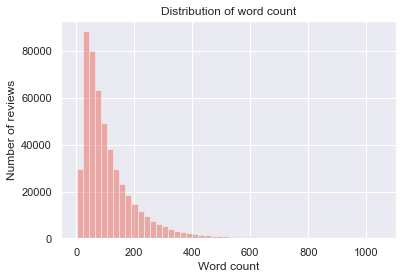

In [9]:
sns.distplot(reviews.word_count, kde=False)
plt.title('Distribution of word count')
plt.xlabel('Word count')
plt.ylabel('Number of reviews')

print('Median review length: {0:0.0f} words'.format(reviews.word_count.median()))
print('Mean review length: {0:0.0f} words'.format(reviews.word_count.mean()))
print('Max review length: {0:0.0f} words'.format(reviews.word_count.max()))

## Text analysis and vectorization

First, let's check some sample reviews

In [10]:
def get_random_review(star, max_length=80):
    """
    Subsets the df based upon the star rating and desired max word count,
    selects a random sample, and returns the value of the 'text' column
    """
    return reviews[(reviews.stars == star) & (reviews.word_count < max_length)].sample(1).text.values[0]

for star in range(1,6):
    print('{0} star review:'.format(star))
    print(get_random_review(star))
    print('\n')

1 star review:
Similar experience to previous reviewers - they charge exuberant fees but aren't transparent during the booking about how much things will cost. You're better off going with a slightly  more expensive car rental company that has more inclusive rates.


2 star review:
It's interested concept but the sushi is not great at all. Most of them has crab mix. A lot of fried and I think they place coloring die on the fish. I will not go back here


3 star review:
Fast and friendly service.  The pizza was made fresh and not busy at all.  I gave it a 3 just because there was nothing that challenged them to make them stand out like a busy lunch crowd.


4 star review:
I still consider the Bellagio buffet to be one of the best on the Strip, and the quality is good regardless of whether it is a peak (dinner on a weekend) or off-peak time (i.e., breakfast).  The buffet has a nice selection and great variety.  The desserts, waffles, and Kobe beef are my favorites at this buffet.


5 sta

In very broad terms, it appears as though it should be possible to distinguish between a positive and negative review based on the inclusion of certain words that are associated with a sentiment. This is the idea behind the bag of words approach that we'll use when examining some linear models. Note that it is less clear from this admittedly small sample that we could distinguish between adjacent classes (ie between say a 3 and 4 star review) using this approach, but we'll try.

### Tf-idf vectorization  
  
To work with ML models, we'll need to convert each word in the review into a consistently formatted numerical vector. We'll do this using Tf-idf (Term frequency, inverse document frequency).  
  
Remember that TF(t,d) is the number of times that the term t appears in document d (ie an intended measure of relevance), and IDF(t,d) is the log of inverse frequency, ie the total number of documents divided by the number of documents that contain the term t. This functions as a weighting that will penalize common words appearing in many documents (so as the number of documents that a word appears in tends towards the total number of documents, IDF tends towards log 1 = 0). Tf-idf is just the product of TF and IDF. 

Scikit-learn implements TfidfVectorizer as a) a count vectorizer, which determines the total vocabulary, creates a dictionary that assigns an integer value to each word, and counts the occurance of each word, followed by b) a tf-idf transformation that reweights the counts into normalized, floating point values. Each document string can then be represented by a vector where words are replaced by their corresponding tf-idf scores.

In [57]:
# Split the review data into training and test sets (we won't use a dev set for this)
x_train, x_test, y_train, y_test = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1)

In [16]:
# Now vectorize the text data

# min_df means exclude rare words that appear in less than 20 of the reviews
# norm l2 means sum of squared vectors will be 1 (euclidean norm) and cosine similarity is the dot product
# ngram_range is set to unigrams and bigrams

vectorizer = TfidfVectorizer(min_df=20, norm='l2', ngram_range=(1, 2), stop_words='english')

# Remember to use fit transform for the training set, to derive the vectors
# but just transform for the test set - we need the test set to be expressed
# using the same features as the training set

features_train = vectorizer.fit_transform(x_train)
features_test = vectorizer.transform(x_test)

print('Number of features from TFIDFVectorizer: %d' % len(vectorizer.get_feature_names()))

Number of features from TFIDFVectorizer: 155080


Each of the 450,000 reviews in the training set is now represented by a vector of 155080 features, which are the tf-idf scores for the unigram and bigrams in the data set.  

At this stage, we can check the terms that are most correlated with each rating 

In [17]:
for rating in sorted(reviews.stars.unique()):
    features_chi2 = chi2(features_train, y_train==rating) # get chi^2 test statistic between feature and rating, only for those lines with the given rating
    indices = np.argsort(features_chi2[0]) # return the indices that would sort the array
    feature_names = np.array(vectorizer.get_feature_names())[indices] # select the words that map to the indices -> the ordering will sort the words from least correlated to most correlated
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1] # create a list of sorted unigrams
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2] # create a list of sorted bigrams
    
    print("\n\nRating: {}".format(rating))
    print("\nMost correlated unigrams:\n{}".format('\n'.join(unigrams[-5:])))
    print("\nMost correlated bigrams:\n{}".format('\n'.join(bigrams[-5:])))
    



Rating: 1

Most correlated unigrams:
terrible
told
horrible
rude
worst

Most correlated bigrams:
horrible service
worst service
stay away
zero stars
waste time


Rating: 2

Most correlated unigrams:
disappointing
meh
ok
mediocre
bland

Most correlated bigrams:
experienced better
food ok
wanted like
food mediocre
tasted like


Rating: 3

Most correlated unigrams:
pretty
okay
average
decent
ok

Most correlated bigrams:
just okay
highly recommend
food ok
pretty good
just ok


Rating: 4

Most correlated unigrams:
tasty
little
bit
pretty
good

Most correlated bigrams:
highly recommend
good food
really good
customer service
pretty good


Rating: 5

Most correlated unigrams:
love
great
best
highly
amazing

Most correlated bigrams:
great job
pretty good
great service
love place
highly recommend


This looks pretty good. Let's see how well a variety of classifiers trained on the vectorized data will perform.

## Model Selection  
  
We'll start by looking at a selection of linear models - Multinomial Naive Bayes\*, Logistic Regression, and a Support Vector Machine. We'll also add an ensemble model (Random Forest Classifier) to see how well that performs. Models will be assessed using f1 scores, which are a blended measure of both precision and recall, after accounting for class imbalance where possible. The approach is to first select the best performing model based solely on default settings, and then tune it to try increase performance.  
  
\* _techincally NB is supposed to use integer counts, but the fractional counts resulting from tf-idf also work_

In [18]:
models = [RandomForestClassifier(n_estimators=200, max_depth=3, class_weight='balanced'),
          MultinomialNB(),
          LinearSVC(class_weight='balanced'),
          LogisticRegression(class_weight='balanced')]
table=[]

for model in models:
    model.fit(features_train, y_train)      # fit the model
    model_name = model.__class__.__name__   # get the name
    accuracies = metrics.f1_score(y_test, model.predict(features_test), average=None)     # create numpy array of f1_score by class

    for label, accuracy in enumerate(accuracies):        
        table.append((model_name, label+1, accuracy))    # store results in a temporary list

acc_df = pd.DataFrame(table, columns=['model_name', 'label', 'f1_score'])    # turn the list of results into a dataframe

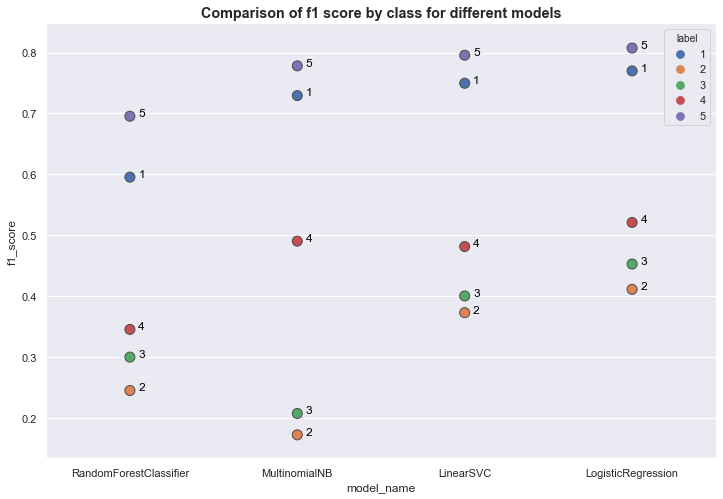

In [19]:
# Use Seaborn stripplot when plotting categorical variables on an axis
plt.subplots(figsize=(12,8))
plt.title("Comparison of f1 score by class for different models", size='large', weight='semibold')
p1 = sns.stripplot(x='model_name', y='f1_score', hue='label', data=acc_df, 
              size=10, edgecolor="gray", jitter=False, linewidth=1, palette='deep')

# This is hacky, but setting the hue based on labels doesn't make it easy enough to distinguish
# the different classes. Instead, loop through the data and annotate each marker with the label
for line in range(0,acc_df.shape[0]):
    p1.text(line//5+0.05, acc_df.f1_score[line], acc_df.label[line],
            horizontalalignment='left', size='medium', color='black')



**Logistic regression** appears to be the best choice overall (ignoring calculation speed, and focusing just on the class-based f1 score). NB, SVM and LR all do fairly well at classifying 5 and 1 start reviews, but LR is better than the others at correctly tagging 2 to 4 star reviews.

## Model Tuning

#### a) Tune the vectorizer

Now that we've selected a model, it is worth seeing whether further gains can be achieved by altering some of the parameters of the tf-idf vectorization. For example, we assumed that having a larger feature set by including bigrams would improve accuracy (effectively by acting as additional regularization), but we didn't test it.

In [20]:
# Get baseline stats
lr = LogisticRegression(class_weight='balanced')
lr.fit(features_train, y_train)
print(metrics.classification_report(y_test, lr.predict(features_test), digits=3))

              precision    recall  f1-score   support

           1      0.729     0.815     0.770      6926
           2      0.426     0.397     0.411      4154
           3      0.459     0.446     0.453      5748
           4      0.536     0.507     0.521     11529
           5      0.803     0.812     0.807     21643

    accuracy                          0.666     50000
   macro avg      0.591     0.595     0.592     50000
weighted avg      0.660     0.666     0.662     50000



In [21]:
# Use sklearn.pipeline.Pipeline to sequentially apply a list of transforms
# Parameters are set by using the name followed by a double underline "__"
# See https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html for details

pipe = Pipeline([
    ('vec', TfidfVectorizer(stop_words='english')), 
    ('model', LogisticRegression(class_weight='balanced'))
    ])

param_grid = {'vec__ngram_range': [(1,1), (1,2)],   # try unigrams and bigrams
              'vec__max_df': [0.3, 0.5],            # ignore common words appearing in more than this proportion of reviews
              'vec__min_df': [0.0001, .001]}     # ignore rare words appearing in less than this proportion of reviews

grid = GridSearchCV(pipe, param_grid, verbose=2)
grid.fit(x_train, y_train)
print('\nBest parameters: ' + str(grid.best_params_))
print(metrics.classification_report(y_test, grid.predict(x_test), digits=3))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 1) ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 1), total= 1.0min
[CV] vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 1) ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 1), total= 1.0min
[CV] vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 1) ....
[CV]  vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 1), total= 1.0min
[CV] vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 2) ....
[CV]  vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 2), total= 2.2min
[CV] vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 2) ....
[CV]  vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 2), total= 2.2min
[CV] vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 2) ....
[CV]  vec__max_df=0.3, vec__min_df=0.0001, vec__ngram_range=(1, 2), total= 2.2min
[CV] vec__max_df=0.3, vec__min_df=0.001, vec__ngram_range=(1, 1) .....
[CV]  vec__max_df=0.3, vec__min_df=0.001, vec__ngram_range=(1, 1), total=  52.3s
[CV] vec__max_df=0.3, vec__min_df=0.001, vec__ngram_range=(1, 1) .....
[CV]  vec__max_df=0.3, vec__min_df=0.001, vec__ngram_range=(1, 1), total=  51.5s
[C

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 35.1min finished



Best parameters: {'vec__max_df': 0.5, 'vec__min_df': 0.0001, 'vec__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           1      0.733     0.814     0.771      6926
           2      0.422     0.406     0.414      4154
           3      0.454     0.443     0.449      5748
           4      0.536     0.503     0.519     11529
           5      0.803     0.812     0.807     21643

    accuracy                          0.665     50000
   macro avg      0.590     0.596     0.592     50000
weighted avg      0.660     0.665     0.662     50000



After all that, the performance wasn't significantly improved - it turns out that leaving in bigrams and excluding a small number of rare words is the optimal choice with this model and data set. 

#### b) Tune the model

In [22]:
lr = GridSearchCV(LogisticRegression(), {'penalty':['l1', 'l2'], 'C': [.1, .5, 1.5, 2]})
lr.fit(features_train, y_train)
print('\nLogistic Regression, best parameters: ' + str(lr.best_params_))
print(metrics.classification_report(y_test, lr.predict(features_test), digits=3))


Logistic Regression, best parameters: {'C': 1.5, 'penalty': 'l1'}
              precision    recall  f1-score   support

           1      0.734     0.835     0.781      6926
           2      0.493     0.287     0.363      4154
           3      0.507     0.348     0.413      5748
           4      0.527     0.483     0.504     11529
           5      0.752     0.876     0.809     21643

    accuracy                          0.670     50000
   macro avg      0.603     0.566     0.574     50000
weighted avg      0.648     0.670     0.652     50000



There is a very small increase in overall accuracy by switching to L1 regularization and weakening C (the regularization factor) from 1 to 1.5, but it comes at the cost of accuracy in the classification of 2-4 star ratings.

## Check errors  
  
#### a) Confusion matrix

In [23]:
lr = LogisticRegression(penalty='l1', class_weight='balanced', C=1.5)
lr.fit(features_train, y_train)
y_pred = lr.predict(features_test)

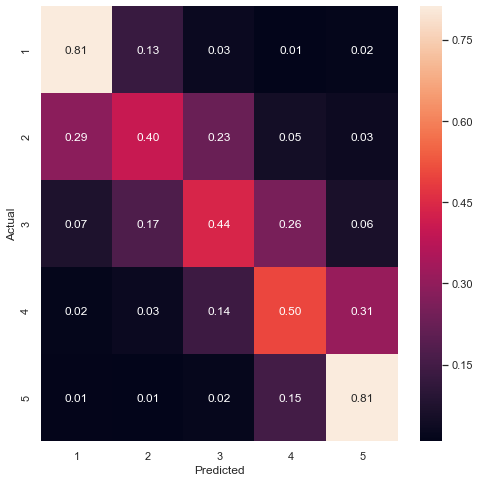

In [28]:
fig, ax = plt.subplots(figsize=(8,8))
conf_mat = confusion_matrix(y_test, y_pred)
# normalize by row totals to address class imbalance
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat, annot=True, fmt='0.2f',
            xticklabels=sorted(reviews.stars.unique()), yticklabels=sorted(reviews.stars.unique()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

As suspected, it is difficult to correctly distinguish between adjacent categories based on the text of the review. To get better results we might need to add training data, or binarize the labels, although that would just mean solving the easier problem of whether a review is positive or negative.

#### b) Largest errors  
  
Define the magnitude of an error to be the difference between the probability assigned to the correct class and the probability assigned to the incorrect class. For example, if the correct class is a 5 star review, and the predictions are P(1 star)=0, P(2 star)=0.01, P(3 star)=0.01, P(4 star)=0.60, P(5 star)=0.38 then the error is 0.38-0.60 = -0.22

In [50]:
pred = lr.predict(features_test)
prob = lr.predict_proba(features_test)

# Create a list containing a tuple for each prediction that was incorrect
# Tuple contains (index, predicted class, actual class, prob(prediction), prob(actual class))
R = [(i, pred[i], y, max(prob[i]), prob[i][y-1]) for i, y in enumerate(y_test) if y != pred[i]]

# Sort by largest errors
R.sort(key=lambda x: x[4]-x[3])

for (i, pred, actual, wrong_prob, right_prob) in R[:5]:       
    print('Review number:', i)
    print('Predicted stars: {0}  Actual stars: {1}'.format(pred, actual))
    print('Prob(prediction): {0:0.3f}   Prob(actual stars): {1:0.3f}'.format(wrong_prob, right_prob))
    print(x_test[i])
    print('\n\n')

Review number: 426
Predicted stars: 5  Actual stars: 4
Prob(prediction): 0.996   Prob(actual stars): 0.004
Well, that was awesome!  Rob is a total super hero, I am extremely pleased and I highly recommend these 



qlly



Review number: 9678
Predicted stars: 1  Actual stars: 5
Prob(prediction): 0.993   Prob(actual stars): 0.003
The club itself is awesome.  Amenities galore and serene.  Beware of front desk worker Lynn M.  She is rude, abrasive and inconsiderate.  Her people skills deserve zero stars however the club itself is awesome!



Review number: 17692
Predicted stars: 5  Actual stars: 4
Prob(prediction): 0.987   Prob(actual stars): 0.005
Let me start by saying Angelo is the owner of Valley of the Sun Violins, and was amazing. He gave his honest opinions on our 18th century violin. It has been in the family for over a hundred years. It has some centimental value, however Angelo made us feel like he would clean it up and make sure it goes to a home that understands the history be

There are two types of problems highlighted here. The first is where the reviewer avoids an extreme star rating despite writing an emphatic review. These would be very difficult for even a human reviewer to predict correctly.

The second problem is where the reviewer includes a 'sub-review' and describes a specific aspect of their experience that doesn't affect their overall rating. This is similar the problem of thwarted expectations, where the reveiwer begins with a set-up that uses words with positive sentiment to explain what they expected, but they then negate it and say that their expectations weren't met. Both are common problems when using a bag of words approach. To deal with them more effectively you need a sequential model, preferably one with memory that can identify when one of the clauses has been negated.   

## Prediction using an RNN  
  
In this section we will implement a very simple recurrent neural network.  It will consist of only 4 layers:
1. An embedding layer for an efficient representation of the training samples
2. A long short term memory layer for the bulk of the prediction power
3. A dropout layer for regularization
4. An output layer  

We'll include a memory component to try to catch longer term dependecies

In [51]:
# Start by tokenizing the reviews. Given the median length is 80 words, we'll assume that reviewers
# can generally get their point across in 160 words - this means we'll cap review length at 160 tokens
# and pad anything shorter than that. To speed things up we'll limit the vocab to 10,000 words

t = Tokenizer(num_words=10000)
t.fit_on_texts(reviews.text)
texts = pad_sequences(t.texts_to_sequences(reviews.text), maxlen=160)

In [59]:
# Use tokenized text to create new train / test sets
x_train_rnn, x_test_rnn, y_train_rnn, y_test_rnn = \
    train_test_split(texts, reviews.stars, test_size=.1)

In [105]:
# Build the model

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=160))
model.add(LSTM(128))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax')) #Dense layer should have 5 categories, and softmax activation for classification

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 160, 128)          1280000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645       
Total params: 1,412,229
Trainable params: 1,412,229
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Convert integer class labels to one hot vectors required for use with categorical_crossentropy loss
from keras.utils import to_categorical
y_bin_train_rnn = to_categorical(y_train_rnn-1)
y_bin_test_rnn = to_categorical(y_test_rnn-1)

In [104]:
# Check that integer class labels have been correctly encoded
print(y_train_rnn[:5])
print(y_bin_train_rnn[:5])

491225    4
185208    1
190171    5
66187     1
78418     2
Name: stars, dtype: int64
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [107]:
model.fit(x_train_rnn, y_bin_train_rnn, epochs=10, batch_size=500, validation_split=.1)

print('\nTest')
score = model.evaluate(x_test_rnn, y_bin_test_rnn, batch_size=100)
print('Loss = {0:0.3f}'.format(score[0]))
print('Accuracy = {0:0.3f}'.format(score[1]))

Train on 405000 samples, validate on 45000 samples
Epoch 1/10
405000/405000 [==============================] - 1869s 5ms/step - loss: 0.8800 - acc: 0.6289 - val_loss: 0.7826 - val_acc: 0.6676
Epoch 2/10
405000/405000 [==============================] - 1767s 4ms/step - loss: 0.7587 - acc: 0.6778 - val_loss: 0.7648 - val_acc: 0.6730
Epoch 3/10
405000/405000 [==============================] - 1761s 4ms/step - loss: 0.7166 - acc: 0.6952 - val_loss: 0.7376 - val_acc: 0.6844
Epoch 4/10
405000/405000 [==============================] - 1757s 4ms/step - loss: 0.6847 - acc: 0.7092 - val_loss: 0.7337 - val_acc: 0.6842
Epoch 5/10
405000/405000 [==============================] - 1758s 4ms/step - loss: 0.6582 - acc: 0.7207 - val_loss: 0.7300 - val_acc: 0.6899
Epoch 6/10
405000/405000 [==============================] - 1770s 4ms/step - loss: 0.6344 - acc: 0.7309 - val_loss: 0.7360 - val_acc: 0.6846
Epoch 7/10
405000/405000 [==============================] - 1775s 4ms/step - loss: 0.6116 - acc: 0.7409

In [118]:
y_pred2 = model.predict_classes(x_test_rnn)+1

In [121]:
print(metrics.classification_report(y_test_rnn, y_pred2, digits=3))

              precision    recall  f1-score   support

           1      0.771     0.794     0.782      6924
           2      0.460     0.470     0.465      4168
           3      0.535     0.437     0.481      5733
           4      0.570     0.462     0.510     11529
           5      0.772     0.877     0.821     21646

    accuracy                          0.685     50000
   macro avg      0.621     0.608     0.612     50000
weighted avg      0.672     0.685     0.675     50000



Even with a fairly simple LSTM and small vocabulary, there is an improvement over logistic regression. We could probably tune the model to improve it further, although it will always be difficult to overcome the issue of subjectivity in the ratings, where the description provided by the reviewer does not contain the entirety of their thought process when they determined the corresponding star rating.

## Final Comparison

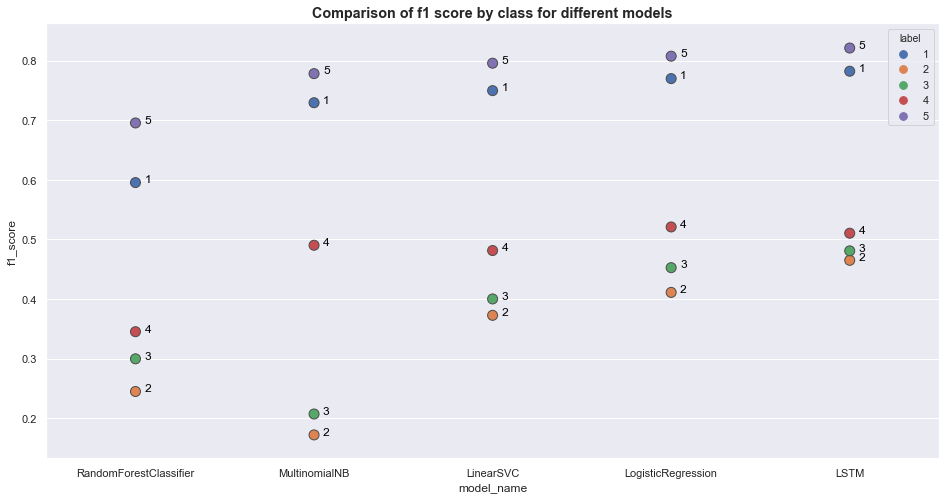

In [145]:
# Get f1 score by categories for the RNN
accuracies = metrics.f1_score(y_test_rnn, y_pred2, average=None)

# Add them to the accuracy dataframe
table = []
for label, accuracy in enumerate(accuracies):        
        table.append(("LSTM", label+1, accuracy))

acc_df_rnn = pd.DataFrame(table, columns=['model_name', 'label', 'f1_score'])
acc_df = acc_df.append(acc_df_rnn, ignore_index=True)

# Use Seaborn stripplot when plotting categorical variables
plt.subplots(figsize=(16,8))
plt.title("Comparison of f1 score by class for different models", size='large', weight='semibold')
p1 = sns.stripplot(x='model_name', y='f1_score', hue='label', data=acc_df, 
              size=10, edgecolor="gray", jitter=False, linewidth=1, palette='deep')

# Annotate each marker with the label
for line in range(0,acc_df.shape[0]):
    p1.text(line//5+0.05, acc_df.f1_score[line], acc_df.label[line],
            horizontalalignment='left', size='medium', color='black')